In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# 1) Theory

We have to initialize the Plummer sphere at equilibrium.

## 1.1) Positions

For the sampling of $r$, $\phi$ and $\theta$, we can apply the direct Monte Carlo sampling method.\
$\phi$ and $\theta$ are distributed uniformly on the surface of a sphere, so we sample $P \in [0,1]$ and then substitute it in:

$$p(\phi) = \dfrac{1}{2\pi} \:\: \Longrightarrow \:\: P(\phi) \, = \, \int^{\phi}_{0} p(\phi')d\phi' \, = \, \int^{\phi}_{0} \dfrac{1}{2\pi}d\phi' \, = \, \dfrac{\phi}{2\pi} \:\: \Longrightarrow \:\: \color{lime} \large \phi(P) = 2\pi P$$

$$p(\theta) = \dfrac{\sin{\theta}}{2} \:\: \Longrightarrow \:\: P(\theta) \, = \, \int^{\theta}_{0} p(\theta')d\theta' \, = \, \int^{\theta}_{0} \dfrac{\sin{\theta'}}{2}d\theta' \, = \, \dfrac{1-\cos{\theta}}{2} \:\: \Longrightarrow \:\: \color{lime} \large \theta(P) = \arccos(1-2P)$$

The sampling of the radial positions according to the Plummer model is more tricky.

- We know that:
  $$\rho(r) \, = \, \dfrac{3M_{tot}}{4\pi b^3} \left(1+\dfrac{r^2}{b^2}\right)^{-5/2} \:\: , \:\: M(r) \, = \, \dfrac{r^3}{(b^2+r^2)^{3/2}}M_{tot}$$ 
  where $b$ is a scale factor.
</br></br>
- Therefore, the radial *pdf* $p(r)$ is given by:
  $$p(r) \, = \, \dfrac{4\pi r^2 \rho(r)}{M_{tot}} \, = \, \dfrac{3r^2}{b^3} \left(1+\dfrac{r^2}{b^2}\right)^{-5/2}$$
</br></br>
- We can integrate it over $r$ (thanks `Mathematica`) to obtain the *cdf* $P(r)$:
  $$P(r) \, = \, \int^{r}_{0} \rho(r')dr' \, = \, \dfrac{r^3}{(b^2+r^2)^{3/2}} \, = \, \dfrac{M(r)}{M_{tot}} \in [0,1]$$
</br></br>
- This relation can be easily inverted:
  $$P^{2/3} \, = \, \dfrac{r^2}{b^2+r^2} \:\: \Longrightarrow \:\: P^{-2/3} \, = \, \dfrac{b^2}{r^2}+1 \:\: \Longrightarrow \:\: \color{lime} \large r(P) \, = \, \dfrac{b}{\sqrt{P^{-2/3}-1}}$$

## 1.2) Velocities

The orientations can be sampled just like $\phi$ and $\theta$, but the magnitudes require more work.

- The distribution of the velocity magnitudes is given by:
  $$F(v) \, = \, \int^{v}_0 f(\epsilon)v'^2dv' \, = \, \int^{v}_0 \left(\psi - \dfrac{v'^2}{2}\right)^{7/2}v'^2dv' \:\:\: , \, \textnormal{where} \:\:\: \color{lime} \large \psi(r) \, = \, -\phi_{G}(r) \, = \, \dfrac{GM_{tot}}{\sqrt{b^2+r^2}}$$
  where the maximum allowed velocity is $v_{escape}(r)=\sqrt{2\psi (r)}$, since for our system to be at equilibrium it is necessary that it is bound.\
  Once the position is known, $\psi(r)$ is straightforward to evaluate, but computing the integral and inverting the solution is very hard.\
  For this reason, the direct-Montecarlo sampling method is not an option and we have to resort to the acceptance-rejection sampling method.
</br></br>
- Let's substitute $q \doteq \dfrac{v}{v_{escape}} = \dfrac{v}{\sqrt{2\psi}} \in [0,1]$, which does not depend on $r$.
  $$F(q) \, = \, \int^{q}_0 \left(\psi-\psi q'^2\right)^{7/2} 2\psi q'^2\sqrt{2\psi}dq' \, = \, 2\sqrt{2}\int^{q}_0 \psi^5(1-q'^2)^{7/2}q'^2dq'$$
</br></br>
- $\psi$ only depends on $r$, while $q$ does not depend on $r$. Therefore, we can take $\psi$ out of the integral.
  $$\color{lime} \large F(q) \, = \, C_{normalization} \int^{q}_0 (1-q'^2)^{7/2}q'^2dq'$$
  Once we have sampled $q$, it is straightforward to convert it back to $v=q\sqrt{2\psi}$.

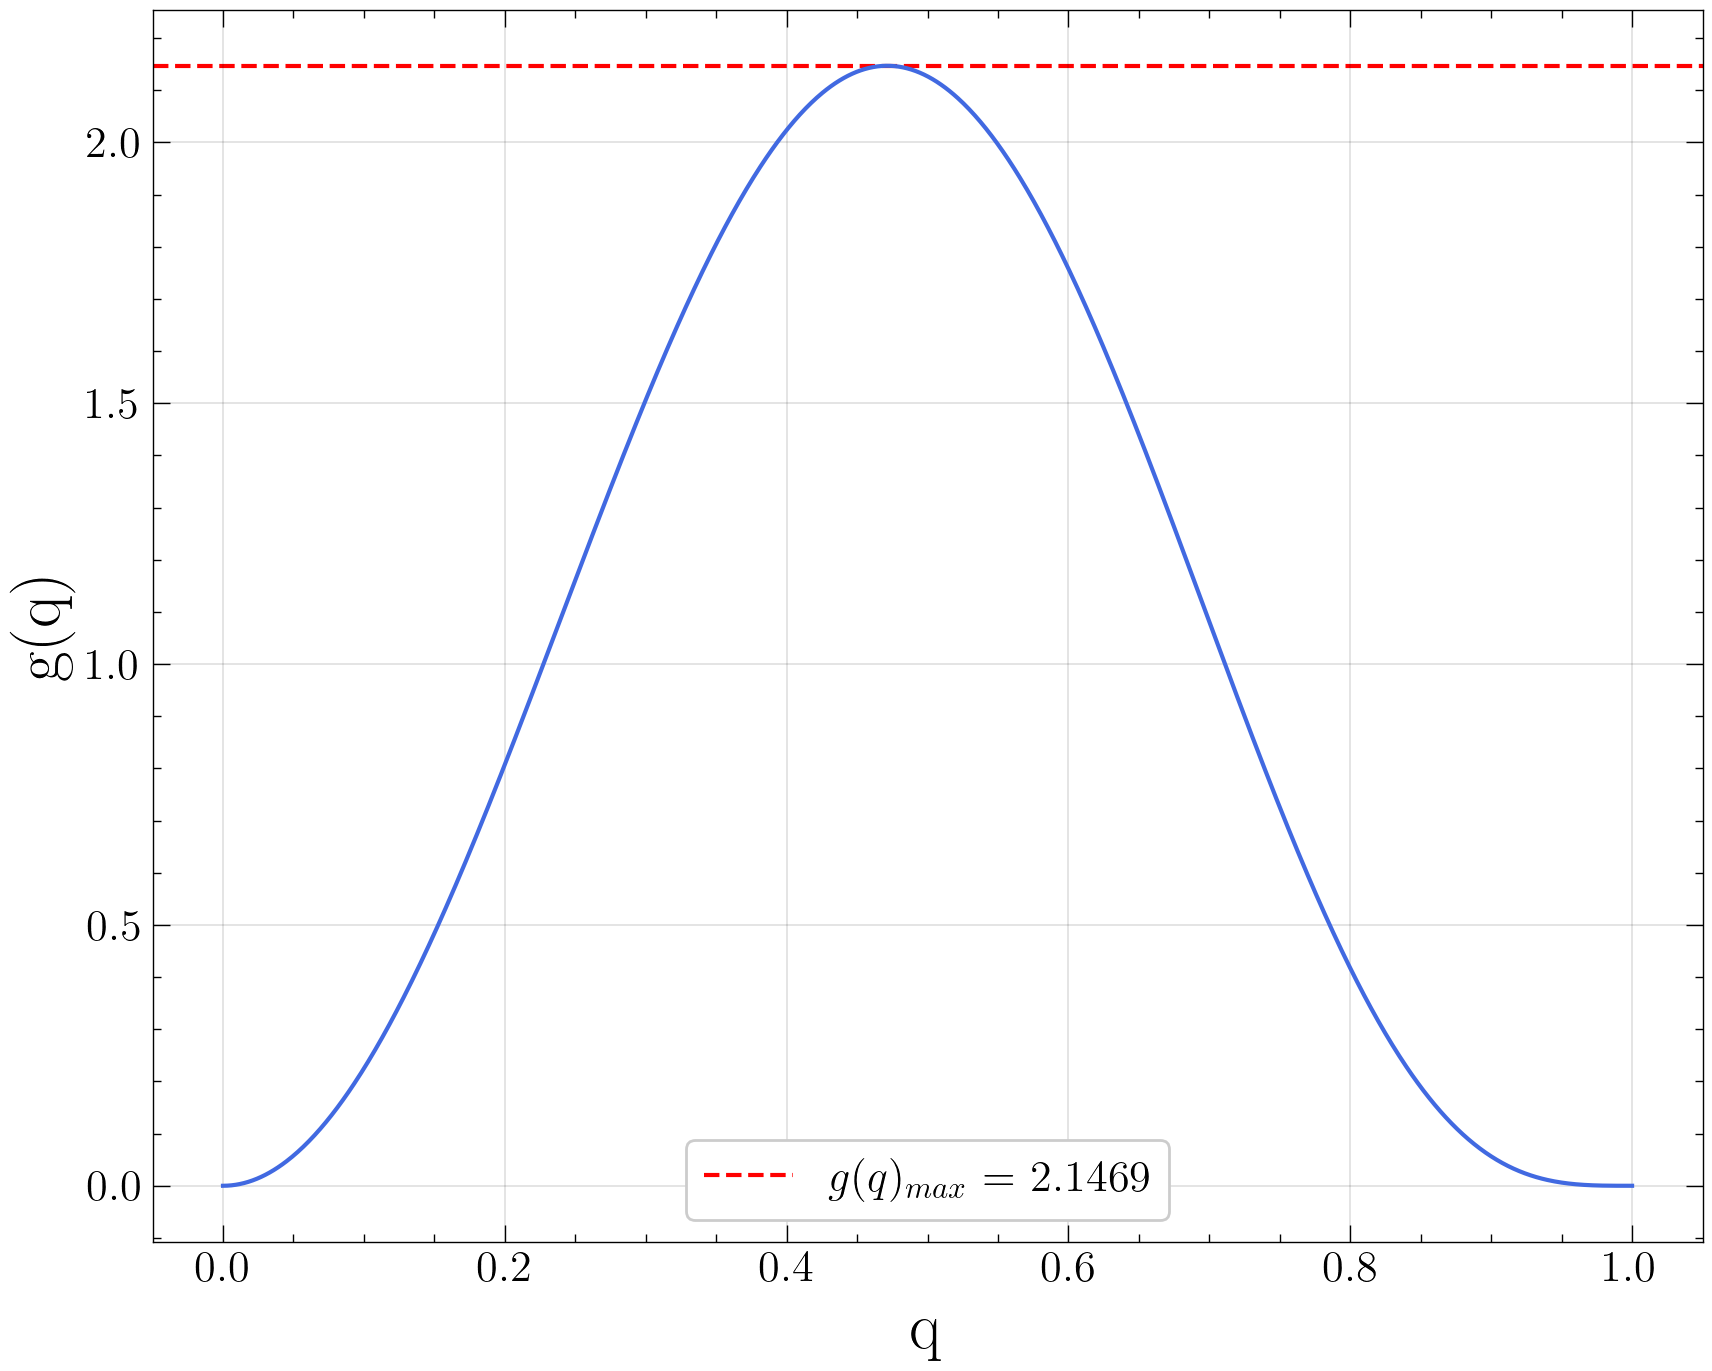

In [2]:
# import scipy.integrate
# scipy.integrate.quad(g_of_q, 0, 1)[0]
C_normalization = 0.04295146206444051 

def g_of_q(x):
    return (x**2)*(1-x**2)**(7/2)/C_normalization

# import scipy.optimize
# -scipy.optimize.fmin(lambda x: -g_of_q(x), x0=0, xtol=1e-9, ftol=1e-9, full_output=1)[1]
g_of_q_max = 2.146860826081696 

x_dense = np.linspace(0, 1, 1000)
plt.plot(x_dense, g_of_q(x_dense), color='royalblue')
plt.axhline(g_of_q_max, ls='--', color='red', label=f'$g(q)_{{max}}$ = {g_of_q_max:.4f}', zorder=0)
plt.xlabel('q')
plt.ylabel('g(q)')
plt.legend();

# 2) Code

In [3]:
N = int(1e4+1) # Number of particles
M = 1        # Total mass
b = 0.1        # Radial scale-factor
m = M/(N-1)      # Mass of the single particles

## 2.1) Positions

Sample in spherical coordinates by using the direct Monte Carlo method

In [4]:
r = b/np.sqrt(np.random.uniform(0, 1, N)**(-2/3) - 1)
phi = 2*np.pi*np.random.uniform(0, 1, N)
theta = np.arccos(1-2*np.random.uniform(0, 1, N))

Transform from spherical coordinates to Cartesian coordinates

In [5]:
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

Check the *pdfs*

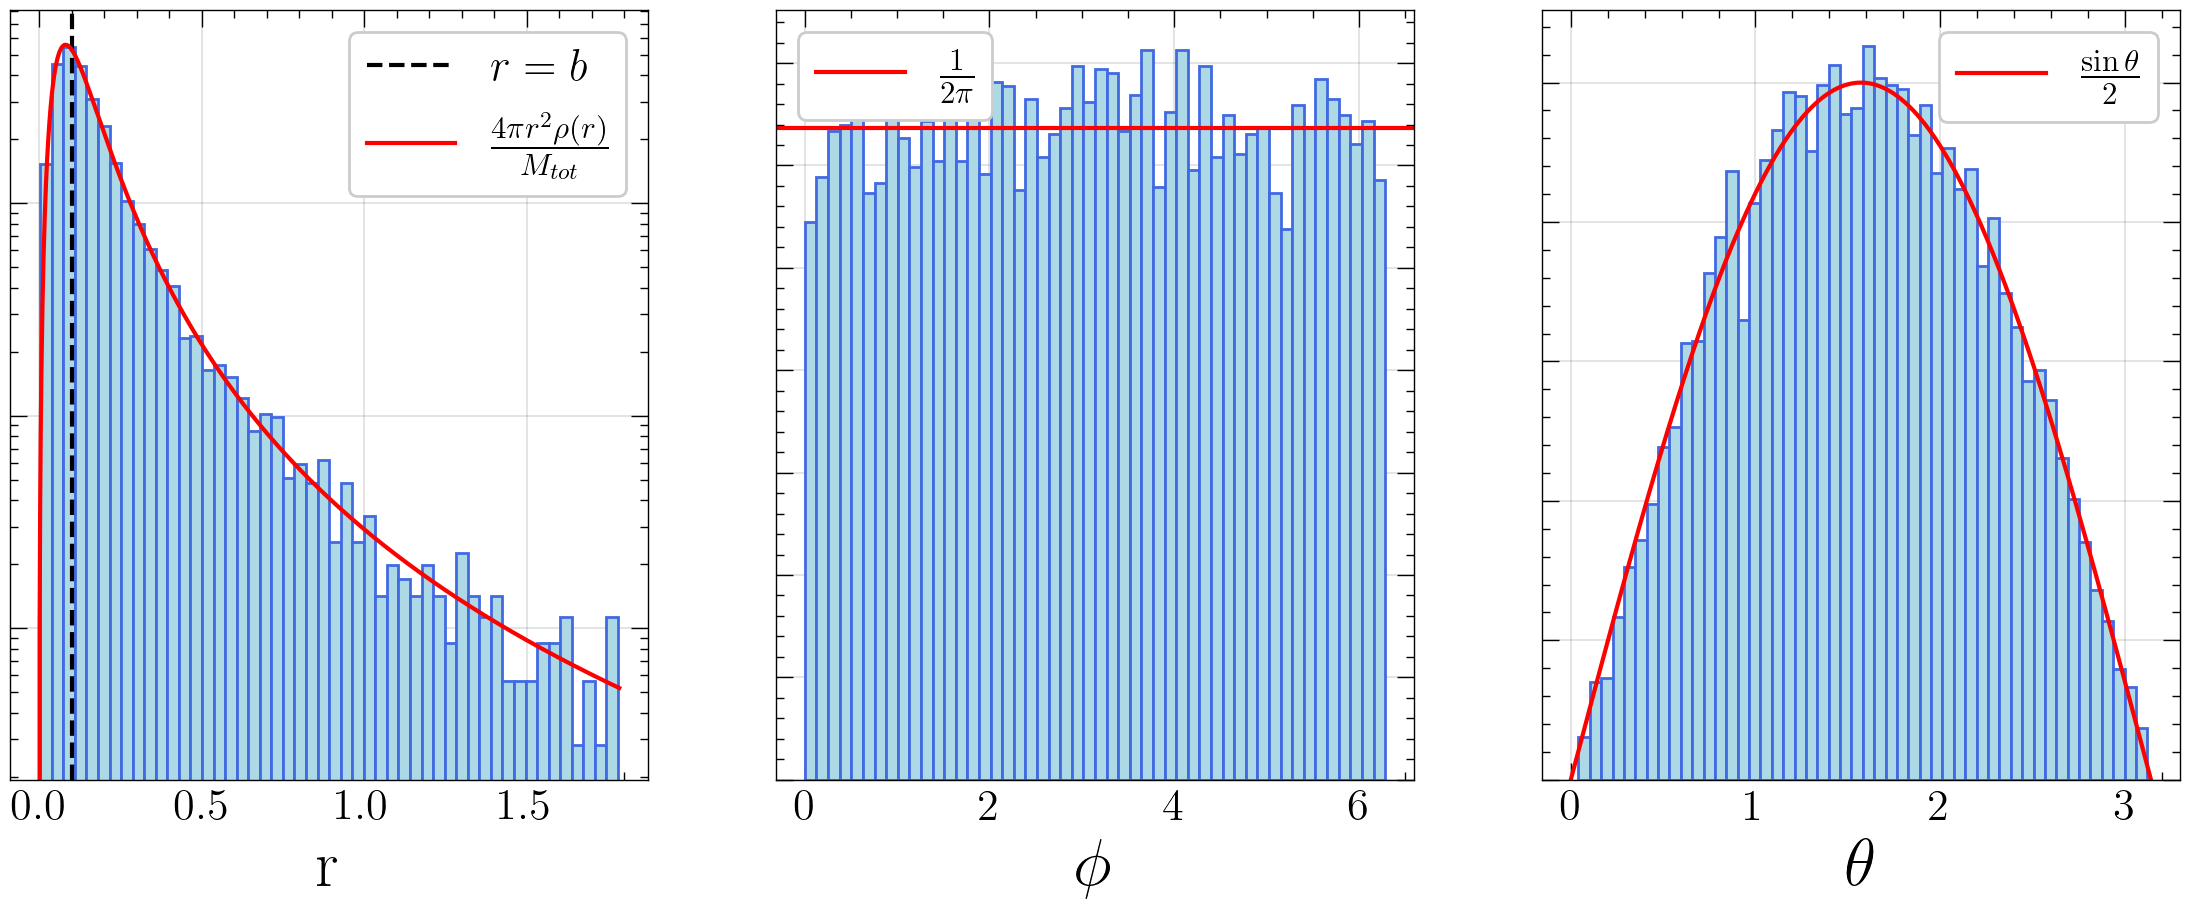

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14,5))

r_max_plot = np.quantile(r, 0.995)
ax = axes[0]
ax.hist(r[r<r_max_plot], bins=50, density=True, color='lightblue', edgecolor='royalblue')
ax.axvline(b, ls='--', color='black', label='$r=b$')
x_dense = np.linspace(0, r_max_plot, 1000)
ax.plot(x_dense, (3*x_dense**2/b**3)*(1+x_dense**2/b**2)**(-5/2), color='red', label='$\\frac{4\pi r^2 \\rho(r)}{M_{tot}}$')
ax.set_yscale('log')
ax.set_xlabel('r')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[1]
ax.hist(phi, bins=50, density=True, color='lightblue', edgecolor='royalblue')
x_dense = np.linspace(0, 2*np.pi, 1000)
ax.axhline(1/(2*np.pi), color='red', label='$\\frac{1}{2\pi}$')
ax.set_xlabel('$\phi$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[2]
ax.hist(theta, bins=50, density=True, color='lightblue', edgecolor='royalblue')
x_dense = np.linspace(0, np.pi, 1000)
ax.plot(x_dense, 0.5*np.sin(x_dense), color='red', label='$\\frac{\sin{\\theta}}{2}$')
ax.set_xlabel('$\\theta$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend();

## 2.2) Velocities

Sample the angles by using the direct Monte Carlo method

In [7]:
phi = 2*np.pi*np.random.uniform(0, 1, N)
theta = np.arccos(1-2*np.random.uniform(0, 1, N))

Sample $q$ by using the acceptance-rejection method

In [8]:
def AcceptanceRejection(N, model, x_min, x_max, y_max):
    sample = np.zeros(N)
    accepted = 0
    
    while accepted<N:
        x = np.random.uniform(x_min, x_max, 1)
        y = np.random.uniform(0, y_max, 1)
        if y <= model(x):
            sample[accepted] = x
            accepted += 1
    return sample

q = AcceptanceRejection(N=N, model=g_of_q, x_min=0, x_max=1, y_max=g_of_q_max)

Check the *pdf* of q

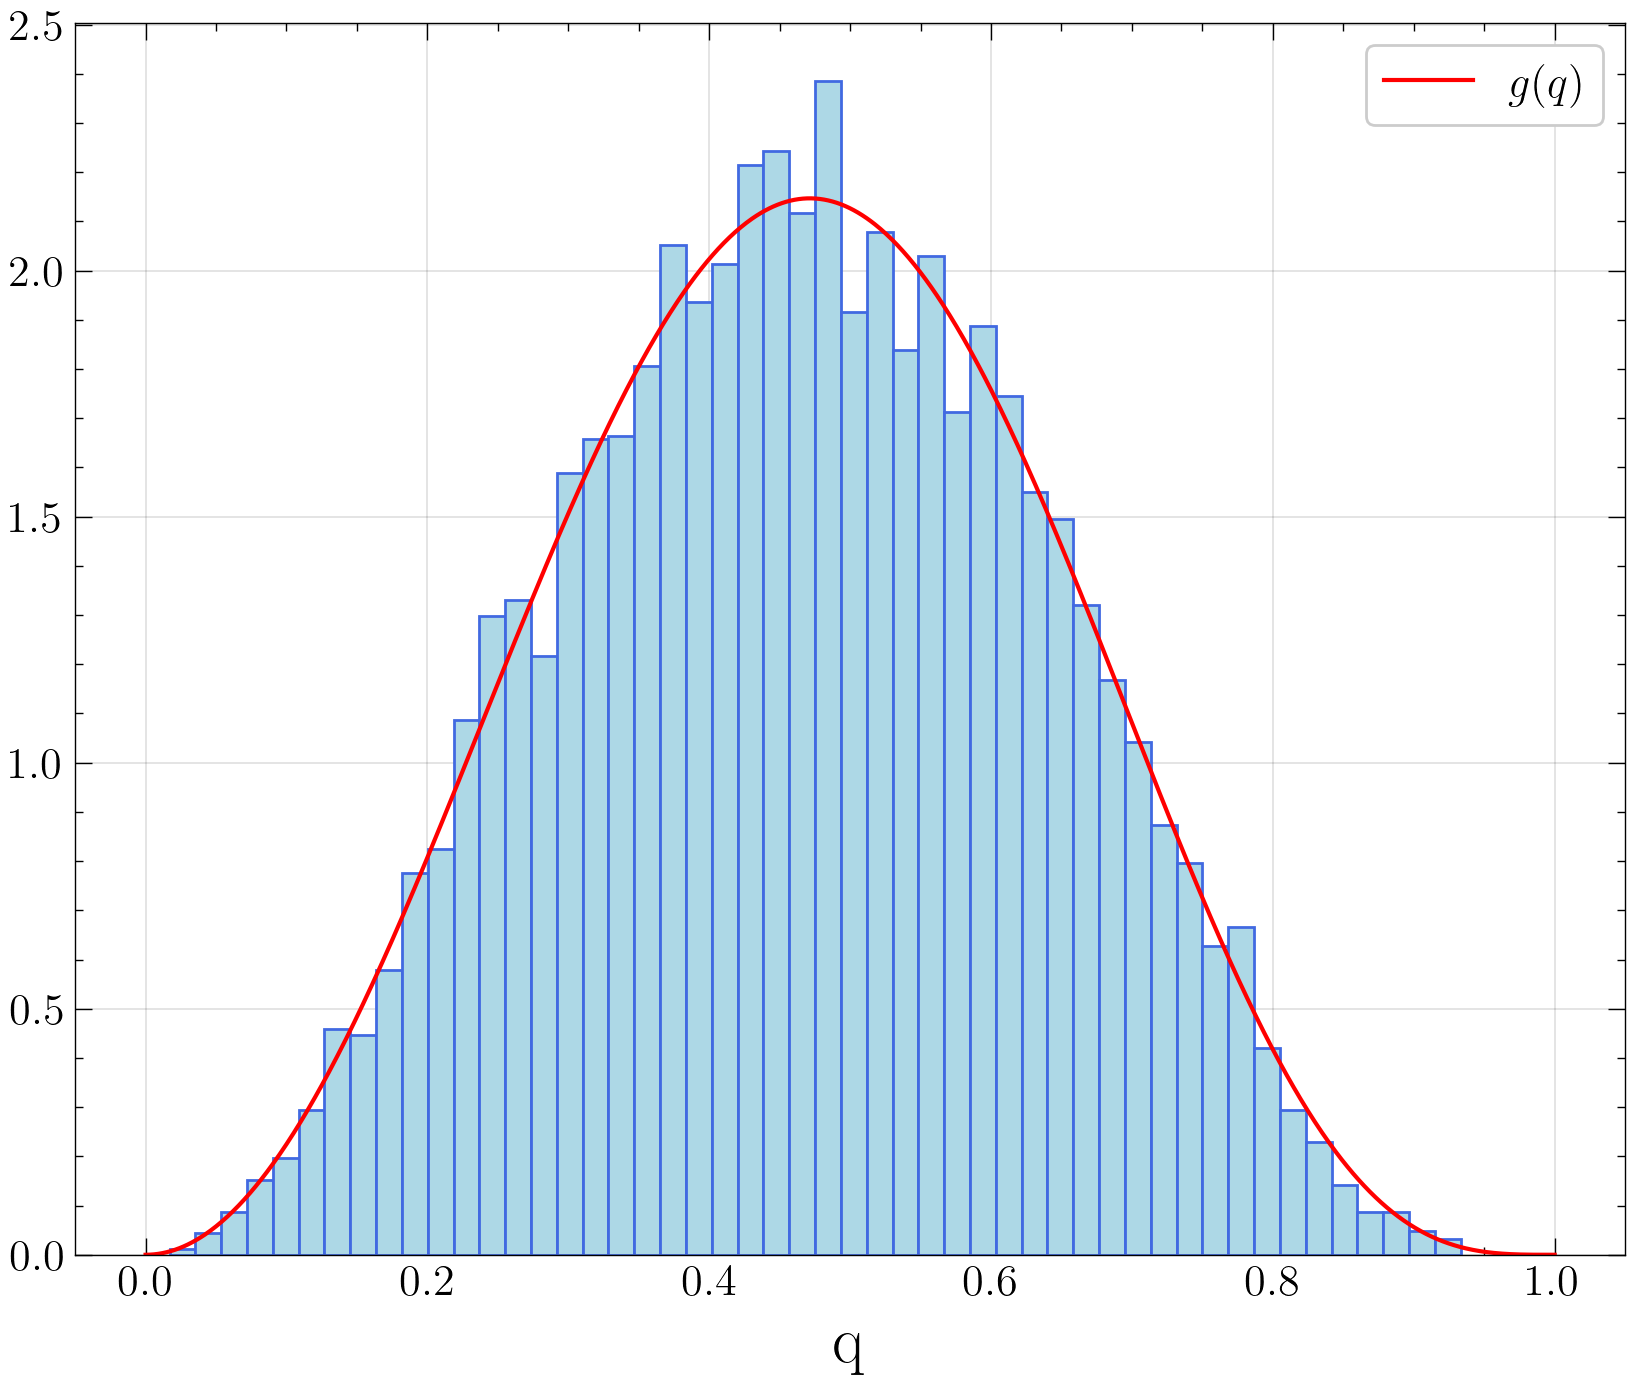

In [9]:
plt.hist(q, bins=50, density=True, color='lightblue', edgecolor='royalblue')
x_dense = np.linspace(0, 1, 1000)
plt.plot(x_dense, g_of_q(x_dense), color='red', label='$g(q)$')
plt.xlabel('q')
plt.legend();

Transform from $q$ to $v=q\sqrt{2\psi(r)}$

In [10]:
def Potential(r):
    return M/np.sqrt(b**2+r**2)

v = q*np.sqrt(2*Potential(r))

Plot the distribution of $v$

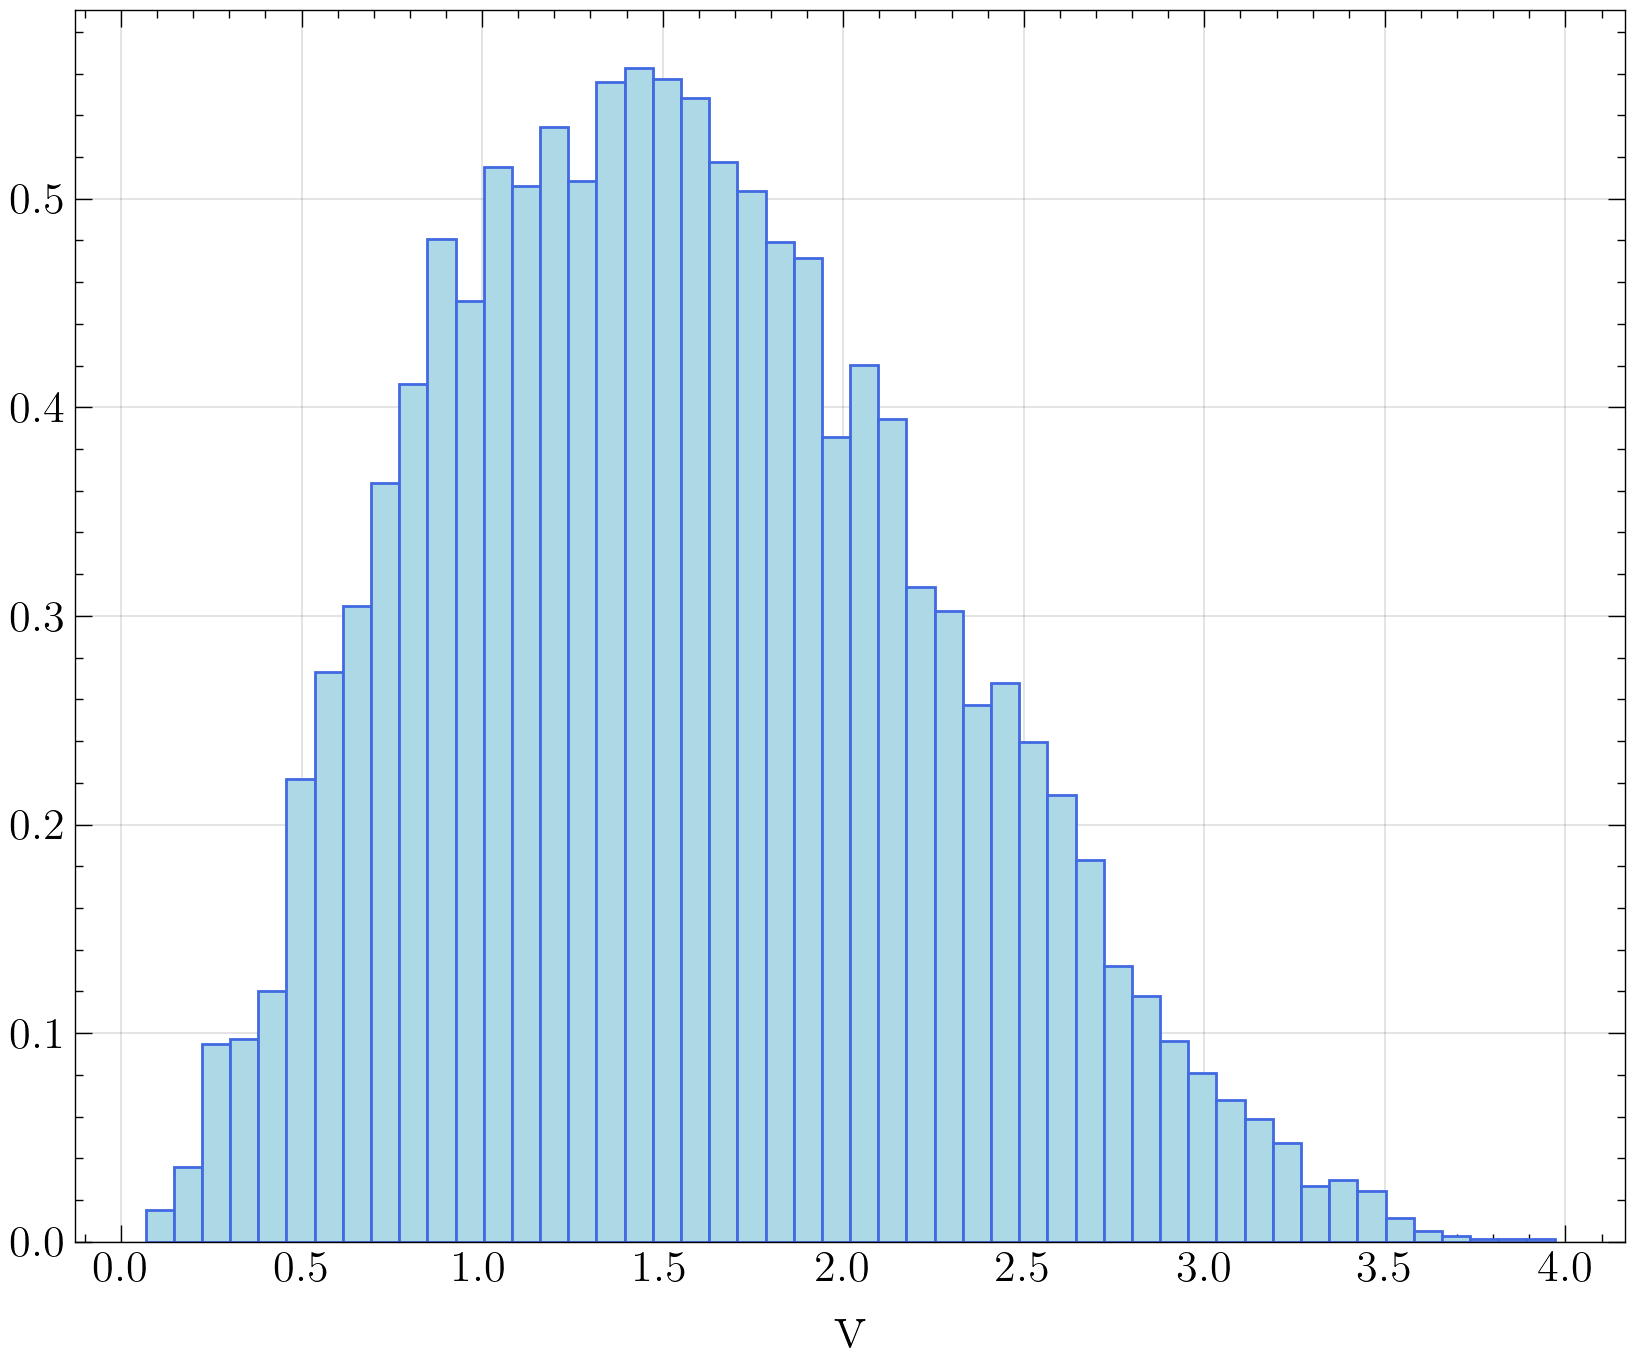

In [11]:
plt.hist(v, bins=50, density=True, color='lightblue', edgecolor='royalblue')
x_dense = np.linspace(0, np.max(v), 1000)
plt.xlabel('v');

Transform from spherical coordinates to Cartesian coordinates

In [12]:
vx = v*np.sin(theta)*np.cos(phi)
vy = v*np.sin(theta)*np.sin(phi)
vz = v*np.cos(theta)

## 2.3) Add the perturber

Since the mass of the perturber must satisfy $M \gg M_{pert} \gg m$, we choose it such that $\frac{M}{M_{pert}} = \frac{M_{pert}}{m}$

$
\begin{cases}
      M = \alpha M_{pert}\\
      M_{pert} = \alpha m\\
      M = mN
\end{cases}
\: \iff \:
\alpha = \dfrac{M}{\sqrt{N}}
$ 

In [13]:
#M_pert = M/np.sqrt(N)
M_pert = (5/100)*M
print(f'M_perturber = {M_pert:.3f}')
print(f'M / M_perturber  = {M/M_pert:.1f}')
print(f'M_perturber / m = {M_pert/m:.1f}')

M_perturber = 0.050
M / M_perturber  = 20.0
M_perturber / m = 500.0


We set the initial position of the perturber such that $r_{pert,0} = {\rm{quantile}}(r; 50\%)$

In [14]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

CMpos_vector = np.array([np.sum(x), np.sum(y), np.sum(z)])/N
CMpos = np.linalg.norm(CMpos_vector)
dist_particle = Dist(x, y, z, CMpos_vector[0], CMpos_vector[1], CMpos_vector[2])
dist_pert = np.quantile(dist_particle, 0.5)
print(f'r_perturber = {dist_pert:.3f}')

r_perturber = 0.131


We have to create an array for the masses

In [15]:
masses = m*np.ones(N)
masses[-1] = M_pert

In [16]:
x[-1] = dist_pert
y[-1] = 0
z[-1] = 0

# 3) Create the input file

In [17]:
# open the file
file = open('friction.in', 'w')

# write the file
file.write(f'{N}\n')
file.write('3\n')
file.write('0\n')

for i in range(N):
    file.write(f'{masses[i]}\n')

for i in range(N):
    file.write(f'{x[i]} {y[i]} {z[i]}\n')
    
for i in range(N):
    file.write(f'{vx[i]} {vy[i]} {vz[i]}\n')

# close the file
file.close()

# 4) Numerical estimation of some parameters

## 4.1) Softening parameter

In [18]:
V_at_b = (4/3)*np.pi*b**3
softening = (V_at_b/N)**(1/3)
print(softening)

0.007481954463467198


## 4.2) Dynamical timescale

In [19]:
r_mean = np.mean(r)
print(f'r_mean = {r_mean:.2f}')

r_mean = 0.20


In [20]:
def Rho(r):
    return (3*M/(4*np.pi*b**3))*(1+(r**2/b**2))**(-5/2)

rho = Rho(r)
rho_mean = np.mean(rho)
print(f'rho_mean = {rho_mean:.3f}')

rho_mean = 44.275


In [21]:
t_dyn = np.sqrt(3*np.pi/(16*rho_mean))
print(f't_dyn = {t_dyn:.2f}')

t_dyn = 0.12
